In [1]:
import pandas as pd
import random
import numpy as np
import torch
from numpy import nan
import math
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

from sklearn import metrics

In [2]:
df = pd.read_csv('/Users/allan/Desktop/GRU_D_EWS/Data/ews_synthetic_data.csv')
df

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs
0,2000.0,382.0,120.0,76.0,47.0,37.574380,8.0,100.0,1.0,True
1,2000.0,497.0,79.0,56.0,105.0,37.999197,14.0,97.0,6.0,True
2,2000.0,621.0,81.0,61.0,113.0,38.539351,9.0,98.0,6.0,True
3,2000.0,726.0,96.0,76.0,106.0,38.026928,17.0,97.0,5.0,True
4,2000.0,851.0,92.0,76.0,101.0,37.813805,13.0,100.0,6.0,True
...,...,...,...,...,...,...,...,...,...,...
47120,2999.0,688.0,111.0,67.0,53.0,38.488368,9.0,100.0,0.0,False
47121,2999.0,1050.0,113.0,76.0,42.0,36.415452,12.0,99.0,1.0,False
47122,2999.0,1443.0,118.0,78.0,51.0,37.414629,6.0,99.0,0.0,False
47123,2999.0,1820.0,128.0,86.0,45.0,37.972787,5.0,99.0,2.0,False


In [1092]:
df

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs,age,mews,ecart,news2
0,2000.0,382.0,120.0,76.0,47.0,37.574380,8.0,100.0,1.0,True,65.0,3,4,9
1,2000.0,497.0,79.0,56.0,105.0,37.999197,14.0,97.0,6.0,True,65.0,3,4,9
2,2000.0,621.0,81.0,61.0,113.0,38.539351,9.0,98.0,6.0,True,65.0,5,8,11
3,2000.0,726.0,96.0,76.0,106.0,38.026928,17.0,97.0,5.0,True,65.0,3,4,8
4,2000.0,851.0,92.0,76.0,101.0,37.813805,13.0,100.0,6.0,True,65.0,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47120,2999.0,688.0,111.0,67.0,53.0,38.488368,9.0,100.0,0.0,False,56.0,0,4,1
47121,2999.0,1050.0,113.0,76.0,42.0,36.415452,12.0,99.0,1.0,False,56.0,1,4,6
47122,2999.0,1443.0,118.0,78.0,51.0,37.414629,6.0,99.0,0.0,False,56.0,2,4,3
47123,2999.0,1820.0,128.0,86.0,45.0,37.972787,5.0,99.0,2.0,False,56.0,3,4,9


In [3]:
df['rr'][(df['rr'] < 1)]  = 5

/var/folders/tc/prmkt2fj0sq_z_h6cdpq8xsh0000gn/T/ipykernel_7098/4180768450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rr'][(df['rr'] < 1)]  = 5


(array([ 3.,  9., 25., 28., 45., 35., 29., 15.,  8.,  3.]),
 array([49.55292833, 53.41406109, 57.27519385, 61.13632661, 64.99745937,
        68.85859213, 72.7197249 , 76.58085766, 80.44199042, 84.30312318,
        88.16425594]),
 <BarContainer object of 10 artists>)

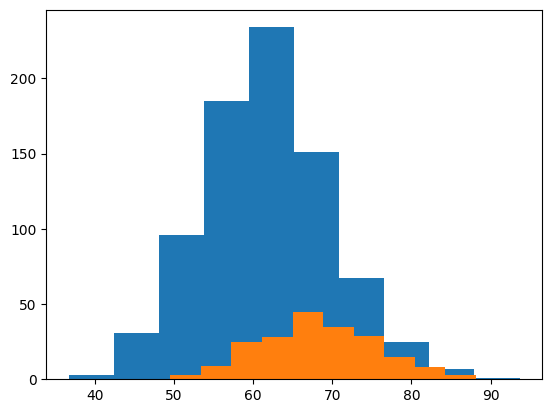

In [189]:
from scipy.stats import poisson, gamma, beta

# Poisson distribution
dead_ages = gamma(a=68, scale=1).rvs(size=200)
alive_ages = gamma(a=62, scale=1).rvs(size=800)

plt.hist(alive_ages)
plt.hist(dead_ages)

In [198]:
ages = np.append(dead_ages,alive_ages).round()
ages

array([65., 58., 50., 68., 74., 66., 76., 62., 74., 66., 66., 65., 73.,
       60., 67., 70., 75., 63., 63., 63., 56., 71., 61., 69., 73., 63.,
       81., 73., 70., 61., 60., 61., 60., 74., 69., 60., 70., 58., 76.,
       68., 62., 75., 78., 81., 84., 72., 64., 56., 77., 71., 63., 84.,
       66., 57., 64., 69., 55., 64., 66., 67., 66., 69., 70., 69., 65.,
       66., 60., 78., 68., 74., 67., 71., 60., 81., 81., 63., 71., 67.,
       76., 73., 74., 57., 67., 62., 80., 69., 67., 78., 57., 77., 64.,
       83., 85., 73., 64., 59., 81., 64., 70., 75., 67., 62., 51., 72.,
       74., 71., 80., 52., 66., 68., 75., 79., 59., 58., 55., 78., 75.,
       78., 79., 75., 68., 60., 66., 61., 67., 61., 69., 68., 88., 68.,
       72., 76., 68., 57., 68., 71., 64., 71., 77., 61., 60., 79., 73.,
       63., 67., 76., 61., 71., 78., 75., 65., 69., 70., 66., 62., 55.,
       61., 61., 68., 62., 72., 68., 69., 64., 69., 59., 60., 55., 75.,
       68., 75., 69., 69., 76., 66., 66., 85., 79., 71., 68., 72

In [199]:
age_episode_dict = dict(zip(df['episode_id'].unique(), ages)) 
age_episode_dict

{2000.0: 65.0,
 2001.0: 58.0,
 2002.0: 50.0,
 2003.0: 68.0,
 2004.0: 74.0,
 2005.0: 66.0,
 2006.0: 76.0,
 2007.0: 62.0,
 2008.0: 74.0,
 2009.0: 66.0,
 2010.0: 66.0,
 2011.0: 65.0,
 2012.0: 73.0,
 2013.0: 60.0,
 2014.0: 67.0,
 2015.0: 70.0,
 2016.0: 75.0,
 2017.0: 63.0,
 2018.0: 63.0,
 2019.0: 63.0,
 2020.0: 56.0,
 2021.0: 71.0,
 2022.0: 61.0,
 2023.0: 69.0,
 2024.0: 73.0,
 2025.0: 63.0,
 2026.0: 81.0,
 2027.0: 73.0,
 2028.0: 70.0,
 2029.0: 61.0,
 2030.0: 60.0,
 2031.0: 61.0,
 2032.0: 60.0,
 2033.0: 74.0,
 2034.0: 69.0,
 2035.0: 60.0,
 2036.0: 70.0,
 2037.0: 58.0,
 2038.0: 76.0,
 2039.0: 68.0,
 2040.0: 62.0,
 2041.0: 75.0,
 2042.0: 78.0,
 2043.0: 81.0,
 2044.0: 84.0,
 2045.0: 72.0,
 2046.0: 64.0,
 2047.0: 56.0,
 2048.0: 77.0,
 2049.0: 71.0,
 2050.0: 63.0,
 2051.0: 84.0,
 2052.0: 66.0,
 2053.0: 57.0,
 2054.0: 64.0,
 2055.0: 69.0,
 2056.0: 55.0,
 2057.0: 64.0,
 2058.0: 66.0,
 2059.0: 67.0,
 2060.0: 66.0,
 2061.0: 69.0,
 2062.0: 70.0,
 2063.0: 69.0,
 2064.0: 65.0,
 2065.0: 66.0,
 2066.0: 6

(array([8.5000e+01, 1.3420e+03, 4.5050e+03, 8.5520e+03, 1.2828e+04,
        1.2070e+04, 4.0280e+03, 3.0460e+03, 6.6400e+02, 5.0000e+00]),
 array([37. , 42.7, 48.4, 54.1, 59.8, 65.5, 71.2, 76.9, 82.6, 88.3, 94. ]),
 <BarContainer object of 10 artists>)

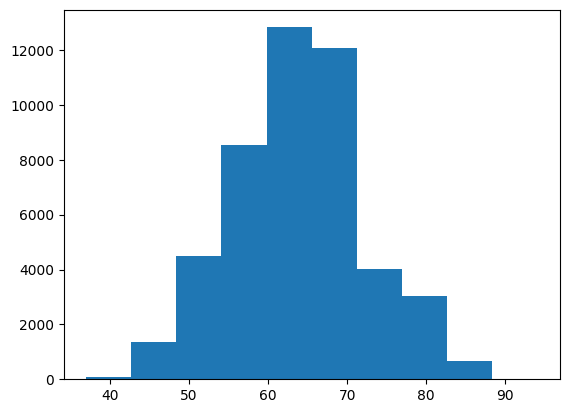

In [202]:
df['age'] = df['episode_id'].map(age_episode_dict)
plt.hist(df['age'])

In [205]:
'''
Functions to calculate NEWS based on MEWS parameters. https://www.mdcalc.com/calc/1875/modified-early-warning-score-mews-clinical-deterioration
'''

def mews_temp (temp):
    if temp == 0:
        return 0
    elif temp <= 35.0:
        return 2
    elif temp >= 38.5:
        return 2
    else:
        return 0

def mews_resp (resp):
    if resp == 0:
        return 0
    elif resp >= 30:
        return 3
    elif resp >= 21:
        return 2
    elif resp >= 15:
        return 1
    elif resp < 9:
        return 2
    else:
        return 0

def mews_hr (hr):
    if hr == 0:
        return 0
    elif hr >= 130:
        return 3
    elif hr >= 111 or hr <= 40 :
        return 2
    elif hr >= 51 and hr <= 90:
        return 0
    else:
        return 1

#Systolic BP only taken into account
def mews_bp (bp):
    if bp == 0:
        return 0
    elif bp >= 200:
        return 2
    elif bp <= 70:
        return 3
    elif bp <=80:
        return 2
    elif bp <=100:
        return 1
    else:
        return 0

# Takes series from DF to extract values to then calculate mews based on functions above 
def mews_calc (x):
    mews = 0
    mews += mews_temp((x['temp']))
    mews += mews_hr(x['hr'])
    mews += mews_resp(x['rr'])
    mews += mews_bp(x['sbp'])
    return mews

In [208]:
'''
Functions to calculate CART based on . https://www.mdcalc.com/calc/10029/cart-cardiac-arrest-risk-triage-score
'''

def cart_age (age):
    if age >= 70:
        return 9
    elif age >= 55:
        return 4
    else:
        return 0

def cart_resp (resp):
    if resp >= 30:
        return 22
    elif resp <= 20:
        return 0
    elif resp <= 23:
        return 8
    elif resp <= 25:
        return 12  
    else:
        return 15

def cart_hr (hr):
    if hr >= 140:
        return 13
    elif hr <= 109:
        return 0
    else:
        return 4   

def cart_dbp (bp):
    if bp >= 50:
        return 0
    elif bp <= 34:
        return 13
    elif bp <= 39:
        return 6
    else:
        return 4

# Takes series from DF to extract values to then calculate NEWS based on functions above 
def cart_calc (x):
    cart = 0
    cart += cart_hr(x['hr'])
    cart += cart_resp(x['rr'])
    cart += cart_age(x['age'])
    cart += cart_dbp(x['dbp'])
    return cart

In [217]:
'''
Functions to calculate NEWS based on NEWS2 parameters. https://www.rcplondon.ac.uk/projects/outputs/national-early-warning-score-news-2
'''

def news_temp (temp):
    if temp == 0:
        return 0
    elif temp <= 35.0:
        return 3
    elif temp >= 39.1:
        return 2
    elif temp >= 36.1 and temp <=39.0:
        return 0
    else:
        return 1

def news_resp (resp):
    if resp == 0:
        return 0
    elif resp <= 8 or resp >= 25:
        return 3
    elif resp >= 21:
        return 2
    elif resp <= 11:
        return 1
    else:
        return 0

def news_hr (hr):
    if hr == 0:
        return 0
    elif hr <= 40 or hr >= 131:
        return 3
    elif hr >= 111:
        return 2
    elif hr >= 51 and hr <= 90:
        return 0
    else:
        return 1

# Assumes not on oxygen, May need to consider how to account for this in the overall calculator
def news_spo2 (spo2, flowrate):
    # Check if on O2
    if flowrate == 0:
        if spo2 == 0:
            return 0
        elif spo2 <= 91 :
            return 3
        elif spo2 <= 93:
            return 2
        elif spo2 <= 95:
            return 1
        else:
            return 0
    else:
        # Being on supplemental O2 + 2
        if spo2 == 0:
            return 0
        elif spo2 <= 83 or spo2 >= 97:
            return 5
        elif spo2 <= 85 or spo2 >= 95:
            return 4
        elif spo2 <= 95 or spo2 >= 93:
            return 3
        else:
            return 0

#Systolic BP only taken into account
def news_bp (bp):
    if bp == 0:
        return 0
    elif bp <= 90 or bp >= 220:
        return 3
    elif bp <= 100:
        return 20
    elif bp <= 110:
        return 1
    else:
        return 0

# Takes series from DF to extract values to then calculate NEWS based on functions above 
def news_calc (x):
    news = 0
    news += (news_temp((x['temp'])))
    news += (news_hr(x['hr']))
    news += (news_resp(x['rr']))
    news += (news_spo2(x['spo2'], x['flow']))
    news += (news_bp(x['sbp']))
    return news


In [219]:
df['mews'] = df.apply(lambda row: mews_calc(row), axis=1)
df['ecart'] = df.apply(lambda row: cart_calc(row), axis=1)
df['news2'] = df.apply(lambda row: news_calc(row), axis=1)
df

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs,age,mews,ecart,news2
0,2000.0,382.0,120.0,76.0,47.0,37.574380,8.0,100.0,1.0,True,65.0,3,4,9
1,2000.0,497.0,79.0,56.0,105.0,37.999197,14.0,97.0,6.0,True,65.0,3,4,9
2,2000.0,621.0,81.0,61.0,113.0,38.539351,9.0,98.0,6.0,True,65.0,5,8,11
3,2000.0,726.0,96.0,76.0,106.0,38.026928,17.0,97.0,5.0,True,65.0,3,4,8
4,2000.0,851.0,92.0,76.0,101.0,37.813805,13.0,100.0,6.0,True,65.0,2,4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47120,2999.0,688.0,111.0,67.0,53.0,38.488368,9.0,100.0,0.0,False,56.0,0,4,1
47121,2999.0,1050.0,113.0,76.0,42.0,36.415452,12.0,99.0,1.0,False,56.0,1,4,6
47122,2999.0,1443.0,118.0,78.0,51.0,37.414629,6.0,99.0,0.0,False,56.0,2,4,3
47123,2999.0,1820.0,128.0,86.0,45.0,37.972787,5.0,99.0,2.0,False,56.0,3,4,9


(array([0.06374005, 0.05248011, 0.02480106, 0.11009284, 0.05291777,
        0.20584881, 0.08994695, 0.01376658, 0.01092838, 0.00047745]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

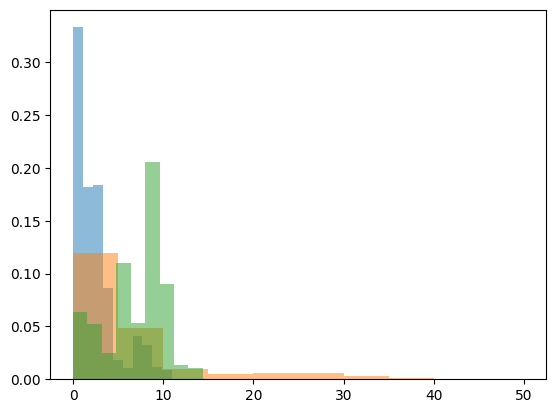

In [222]:
plt.hist(df['mews'], alpha = 0.5, density= True)
plt.hist(df['ecart'], alpha = 0.5, density= True)
plt.hist(df['news2'], alpha = 0.5, density= True)

In [639]:
def plot_vitals_labels (episode_id):
    data = df[df['episode_id'] == episode_id]
    fig, ax1 = plt.subplots()
    ti = data['anchor_time']
    # Plot the first dataset with ax1

    line1, = ax1.plot(ti,  data['sbp'], linewidth = 0.5, label='SBP (mmHg)')
    line2, = ax1.plot(ti,  data['dbp'], linewidth = 0.5, label='DBP(mmHg)')
    line3, = ax1.plot(ti,  data['hr'], linewidth = 0.5, label='HR (bpm)')
    line4, = ax1.plot(ti,  data['temp'], linewidth = 0.5, label='Temp ($^o$C)')
    line5, = ax1.plot(ti,  data['rr'], linewidth = 0.5, label='RR (min$^-$$^1$)')
    line6, = ax1.plot(ti,  data['spo2'], linewidth = 0.5, label='SpO$_2$ (%)')
    line7, = ax1.plot(ti,  data['flow'], linewidth = 0.5, label='O$_2$ Flow Rate (L/min)')

    ax1.set_xlabel('Time Since Admission (Min)')
    ax1.set_ylabel('Vitals')
    ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    a = data[data['outcome_in_24hrs'] == 0]
    d = data[data['outcome_in_24hrs'] == 1]

    ax2.scatter(a['anchor_time'], a['outcome_in_24hrs'], color = 'forestgreen', marker= 'X', label='Y2 Data')
    ax2.scatter(d['anchor_time'], d['outcome_in_24hrs'], color = 'firebrick', marker= 'X', label='Y2 Data')
    ax2.set_ylabel('Ground Truth Labels')
    ax2.set_yticks([0,1], labels= ['Stable', 'Unstable'])
    ax2.set_ylim(-0.05,1.05)
    
    ax2.set_title('Vital Signs with Labels of Episode ID: ' + str(episode_id))
    plt.show()

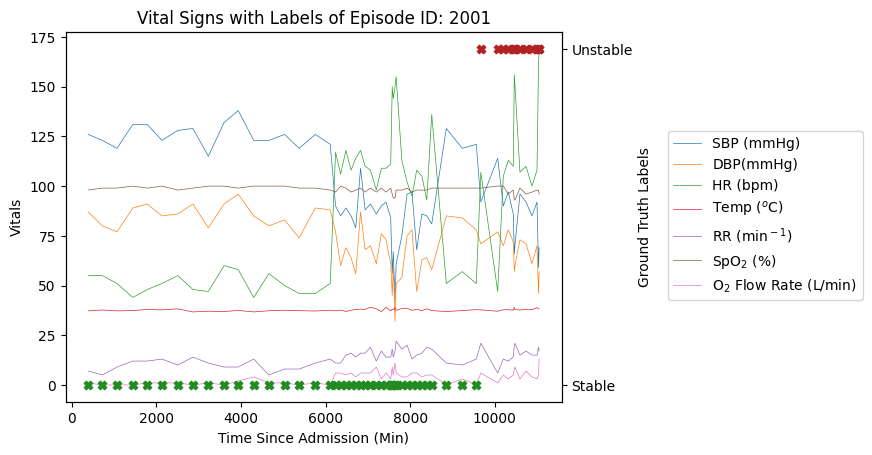

In [641]:
plot_vitals_labels(2001)

In [6]:
from pre_processing_func import *



In [9]:
cols =[ 'anchor_time',	'sbp',	'dbp',	'hr',	'temp',	'rr',	'spo2',	'flow']


def train_val_test_split(data, labels, train_prop = 0.7, val_prop = 0.1, test_val = 0.2):
    
    assert train_prop + val_prop + test_val == 1, 'Proportions must = 1'

    sample_size = data.shape[0]
    index = np.arange(sample_size, dtype = int)
    np.random.seed(1024) # If crossval - This would need to change
    np.random.shuffle(index)
    
    data = data[index]
    
    labels = labels[index]
    
    # Get indices of when training/validation/test split    
    train_index = int(np.floor(sample_size * train_prop))
    valid_index = int(np.floor(sample_size * ( train_prop + val_prop)))
    
    train_data, train_label = data[:train_index], labels[:train_index] 
    valid_data, valid_label = data[train_index:valid_index], labels[train_index:valid_index]
    test_data, test_label = data[valid_index:], labels[valid_index:]

    return train_data, train_label, valid_data, valid_label, test_data, test_label , index[valid_index:]

def df_to_np_pipe (df,cols, time_steps_req):
    '''
    Takes df with vital signs and returns an np.array of data and array of episode order
    Input: DF (Spell, Time_step, Vitals signs....), number of time steps required
    Returns: np.array (Batch, Time_step, Features)
    Feature order: Time_lag, RR, SBP, DBP, HR, Temp, Spo2
    '''
    # Batch, seq_len, features
    episodes = df['episode_id'].unique()
    
    X = np.zeros((len(episodes), time_steps_req, len(cols)))

    Y = -np.ones((len(episodes), time_steps_req))

    id = 0
    for epi in episodes:
        data = (df[df['episode_id'] == epi]).reset_index() # Reset so you can directly index
        length = len(data)
        # If spell has less than required, add available data to beginning of array
        #Using Loc you have to directly index rather than reverse slice
        if length < time_steps_req:
            X[id,:length,:] = data.loc[0:length, cols].to_numpy()
            Y[id,:length] = data.loc[0:length, 'outcome_in_24hrs'].to_numpy()
            id += 1
        # If spell has more than required, last x time_steps of spell goes to data
        else:
            X[id,:,:] = data.loc[length-time_steps_req:length, cols].to_numpy()
            Y[id,:] = data.loc[length-time_steps_req:length, 'outcome_in_24hrs'].to_numpy()
            id += 1
    
    return X, Y, episodes

X, Y, episodes = df_to_np_pipe(df,cols,200)

In [10]:
train_data, train_label, valid_data, valid_label, test_data, test_label, test_idx= train_val_test_split(X, Y)
print ('Train Length', len(train_data), 'Event rate:', train_label.max(axis=1).sum()/len(train_label))
print ('Val Length', len(valid_data), 'Event rate:', valid_label.max(axis=1).sum()/len(valid_label))
print ('Test Length', len(test_data), 'Event rate:', test_label.max(axis=1).sum()/len(test_label))

Train Length 700 Event rate: 0.2042857142857143
Val Length 99 Event rate: 0.2222222222222222
Test Length 201 Event rate: 0.17412935323383086


In [11]:
from pre_processing_func import *

gru_train_x, gru_train_len, gru_train_timings, X_mean, train_means, train_std, max_delta  = train_mask_delta_generator(train_data)
gru_val_x, gru_val_len, gru_val_timings = val_test_mask_delta_generator(valid_data,train_means, train_std, max_delta)

# gru_val_x, gru_val_len, gru_val_timings  = val_test_mask_delta_generator(valid_data, train_means, train_std, max_delta)
# gru_test_x, gru_test_len, gru_test_timings = val_test_mask_delta_generator(test_data,   train_means, train_std, max_delta)


Start to generate Mask, Delta, Last_observed_X ...
Finished
Start to generate Mask, Delta, Last_observed_X ...
Finished


In [12]:
gru_test_x, gru_test_len, gru_test_timings = val_test_mask_delta_generator(test_data,train_means, train_std, max_delta)

Start to generate Mask, Delta, Last_observed_X ...
Finished


In [11]:
def val_test_mask_delta_generator (data, train_means, train_std, max_delta):
    ''' Normalises and generates masks required for decay learning
    Learns parameters for normalisation and passes on to val_test generator
    Takes: data array (Sample, Time_Step, Feature), 
    train_means, train_std, max_delta - parameters from training for normalisation 
    Returns 
    Model input(Sample, model input(4), time_step, feature)
    Length: Array seq_len for trimming (sample)
    '''
    print('Start to generate Mask, Delta, Last_observed_X ...')

    flow = data[:,:,7]
    data[:,:,7][flow == 0] = 0.1
    data[data == 0] = np.nan
    X = data[:,:,1:].round()

    # Where there is no observation 
    Mask = (X != -1)    
    # Normalise data to training ranges
    X = (X - train_means) / train_std
    
    # Get lags from first index
    lags = np.diff(data[:,:,0])
    # Alter the anchor_time to time_lags
    time_lags = data[:,:,0]
    time_lags[:,1:] = lags


    # Find the lengths of each time series
    
    lengths =  (~np.isnan(time_lags)).sum(axis = 1)
    

    # # Time_lags is S vector in paper -> Contains time lags of all examples (N x Time_steps)
    # time_lags = np.zeros((data.shape[0],data.shape[1]))
    # # Get lags from first index
    # time_lags[:,1:] = data[:,1:,0]

    Delta = np.repeat(time_lags, X.shape[2], axis=1) # Like np.tile
    Delta = np.reshape(Delta, X.shape) # Reshape into data matrix shape
    
    X_last_obsv = np.copy(X)
    # Get the idx access
    missing_index = np.where(Mask == 0)
    # I: batch, j: time_step, k: feature
    for idx in range(missing_index[0].shape[0]):
        # Selects where there is a missing according to mask
        i = missing_index[0][idx] 
        j = missing_index[1][idx]
        k = missing_index[2][idx]
            # If previous not missing then delta = current time lag last observed + previous
        if j != 0 and j != (X.shape[1]-1): # This logic is to avoid first and last! need to alter j needs to be time step
            Delta[i,j+1,k] = Delta[i,j+1,k] + Delta[i,j,k]
        if j != 0:
            X_last_obsv[i,j,k] = X_last_obsv[i,j-1,k] # last observation
    # normalize - currently max/min scaled keeps 0-1
    Delta = Delta / max_delta

    X = np.expand_dims(X, axis=1)
    X_last_obsv = np.expand_dims(X_last_obsv, axis=1)
    Mask = np.expand_dims(Mask, axis=1)
    Delta = np.expand_dims(Delta, axis=1)
    dataset_agger = np.concatenate((X, X_last_obsv, Mask, Delta), axis = 1)

    print('Finished')
    
    return dataset_agger , lengths,  np.cumsum(time_lags, axis = 1)

In [603]:
def dataset_compiler_gru_shorten (data, labels, lengths, timings, hrs_inclusion_criteria = 24, hrs_trim = 48):
    '''
    Removes instances where there are not enough observations
    Trims each instance based on the length of admission from the mask_generator

    Takes: Data array, label array, length array, timings (anchor_time)
    Returns: Dataset
    '''
    # Exclude instances < 24hrs (1440 mins)
    inclusion_mask = np.nanmax(timings, axis = 1) >= (hrs_inclusion_criteria*60)
    data = data[inclusion_mask]
    labels = labels[inclusion_mask]
    lengths = lengths[inclusion_mask]
    timings = timings[inclusion_mask]

    # Find the time_steps within 48hrs of end of admission (2880 min)
    threshold_48 = np.nanmax(timings, axis = 1) - (hrs_trim*60)
    within_48 = (timings) >= threshold_48[:,np.newaxis]
    # First index within 48hrs
    indices_48 = np.where(within_48.any(axis=1), within_48.argmax(axis=1), -1)
    
    # Holding list to capture incoming tensors
    X = []
    y = []
    seq_timings = []
    # Iteratrates through length array and trims data array in the time_step dim

    for id in range(len(data)):
        start = int(indices_48 [id])
        end = int(lengths [id])
        X.append(torch.Tensor(data[id,:,start:end,:]))
        y.append(torch.Tensor(labels[id,start:end]))
        seq_timings.append(np.array(timings[id,start:end]))
    
    # Combines list of tensors and labels
    dataset = CustomDataset(X, y)

    return  dataset, seq_timings

def dataset_compiler_gru_full_time(data, labels, lengths, timings, hrs_inclusion_criteria = 24):
    '''
    Removes instances where there are not enough observations
    Trims each instance based on the lengths from the mask_generator
    Use this for the test set to give representive sample of the real world (i.e. throughout the admission)

    Takes: Data array, label array, length array, , timings (anchor_time)
    Returns: Dataset
    '''
    # Exclude instances < 24hrs (1440 mins)
    inclusion_mask = np.nanmax(timings, axis = 1) >= (hrs_inclusion_criteria *60)
    data = data[inclusion_mask]
    labels = labels[inclusion_mask]
    lengths = lengths[inclusion_mask]
    timings = timings[inclusion_mask]
    
    
    # Holding list to capture incoming tensors
    X = []
    y = []
    # Iteratrates through length array and trims data array in the time_step dim
    # id = 0
    for id in range(len(data)):
        end = int(lengths [id])
        X.append(torch.Tensor(data[id,:,:end,:]))
        y.append(torch.Tensor(labels[id,:end]))

    # Combines list of tensors and labels
    dataset = CustomDataset(X, y)

    return dataset, inclusion_mask

In [14]:
gru_train_timings

array([[ 375.,  734., 1117., ...,   nan,   nan,   nan],
       [ 350.,  720., 1096., ...,   nan,   nan,   nan],
       [ 353.,  716., 1056., ...,   nan,   nan,   nan],
       ...,
       [ 363.,  760., 1112., ...,   nan,   nan,   nan],
       [ 355.,  721., 1078., ...,   nan,   nan,   nan],
       [ 348.,  738., 1119., ...,   nan,   nan,   nan]])

In [49]:
gru_train_dataset = dataset_compiler_gru_shorten(gru_train_x, train_label, gru_train_len, gru_train_timings, 24, 48)
gru_val_dataset = dataset_compiler_gru_shorten(gru_val_x, valid_label, gru_val_len, gru_val_timings, 24, 48)
gru_test_dataset_long  = dataset_compiler_gru_full_time(gru_test_x, test_label, gru_test_len, gru_test_timings)
gru_test_dataset_short  = dataset_compiler_gru_shorten(gru_test_x, test_label, gru_test_len, gru_test_timings, 24, 24)

gru_train_dataloader = dataloader_compiler (gru_train_dataset, batch_size = 20)
gru_val_dataloader = dataloader_compiler (gru_val_dataset, batch_size = 1)

# Testing allows for assessment per patient
gru_test_dataloader_long = DataLoader(gru_test_dataset_long, batch_size= 1, shuffle= False)
gru_test_dataloader_short = DataLoader(gru_test_dataset_short, batch_size= 1, shuffle= False)

In [604]:
gru_test_dataset_short, short_timings  = dataset_compiler_gru_shorten(gru_test_x, test_label, gru_test_len, gru_test_timings, 24, 24)
gru_test_dataloader_short = DataLoader(gru_test_dataset_short, batch_size= 1, shuffle= False)

In [385]:
gru_test_dataset_long, indice_mask  = dataset_compiler_gru_full_time(gru_test_x, test_label, gru_test_len, gru_test_timings, 24)
gru_test_dataloader_long = DataLoader(gru_test_dataset_long, batch_size= 1, shuffle= False)

In [64]:
(t[0]).max()- t[0] 

array([1414., 1068.,  724.,  355.,    0.])

In [206]:
np.where(np.isnan(np.stack(X[142][0])))

(array([53]), array([4]))

In [208]:
episodes[404]

2404.0

In [207]:
dataset_idx[142]

404

In [16]:

def Train_Binary_Model(model, train_dataloader, valid_dataloader, num_epochs = 300, patience = 10, min_delta = 0.00001, learning_rate = 0.00001):
    
    print('Model Structure: ', model)
    print('Start Training ... ')
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
        print('Output type dermined by the last layer')
    else:
        output_last = model.output_last
        print('Output type dermined by the model')
        
    loss_MSE = torch.nn.BCELoss()    
    
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    use_gpu = torch.cuda.is_available()
    if use_gpu == False:
        device = 'cpu'

    losses_train = []
    losses_valid = []
    losses_epochs_train = []
    losses_epochs_valid = []
    
    cur_time = time.time()
    pre_time = time.time()
    
    # Variables for Early Stopping
    is_best_model = 0
    patient_epoch = 0
    for epoch in range(num_epochs):
        
        trained_number = 0
       
        valid_dataloader_iter = iter(valid_dataloader)
        
        losses_epoch_train = []
        losses_epoch_valid = []
        
        for data in train_dataloader:
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else: 
                inputs, labels = inputs.to(device), labels.to(device)
            
            model.zero_grad()

            outputs = model(inputs)
            
            loss_train = loss_MSE(torch.squeeze(outputs), torch.squeeze(labels))
           
            losses_train.append(loss_train.data)
            losses_epoch_train.append(loss_train.data)
            
            optimizer.zero_grad()
            
            loss_train.backward()
            
            optimizer.step()
            
             # validation 
            try: 
                inputs_val, labels_val = next(valid_dataloader_iter)
            except StopIteration:
                valid_dataloader_iter = iter(valid_dataloader)
                inputs_val, labels_val = next(valid_dataloader_iter)
            
            if use_gpu:
                inputs_val, labels_val = inputs_val.cuda(), labels_val.cuda()
            else: 
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
            

            model.zero_grad()
            
            outputs_val = model(inputs_val)
         
            loss_valid = loss_MSE(torch.squeeze(outputs_val), torch.squeeze(labels_val))
            
            losses_valid.append(loss_valid.data)
            losses_epoch_valid.append(loss_valid.data)
            
            # output
            trained_number += 1
            
        avg_losses_epoch_train = sum(losses_epoch_train).cpu().numpy() / float(len(losses_epoch_train))
        avg_losses_epoch_valid = sum(losses_epoch_valid).cpu().numpy() / float(len(losses_epoch_valid))
        losses_epochs_train.append(avg_losses_epoch_train)
        losses_epochs_valid.append(avg_losses_epoch_valid)
        
        # Early Stopping
        if epoch == 0:
            is_best_model = 1
            best_model = model
            min_loss_epoch_valid = 10000.0
            if avg_losses_epoch_valid < min_loss_epoch_valid:
                min_loss_epoch_valid = avg_losses_epoch_valid
        else:
            if min_loss_epoch_valid - avg_losses_epoch_valid > min_delta:
                is_best_model = 1
                best_model = model
                min_loss_epoch_valid = avg_losses_epoch_valid 
                patient_epoch = 0
            else:
                is_best_model = 0
                patient_epoch += 1
                if patient_epoch >= patience:
                    print('Early Stopped at Epoch:', epoch)
                    break
        
        # Print training parameters
        cur_time = time.time()
        print('Epoch: {}, train_loss: {}, valid_loss: {}, time: {}, best model: {}'.format( \
                    epoch, \
                    np.around(avg_losses_epoch_train, decimals=8),\
                    np.around(avg_losses_epoch_valid, decimals=8),\
                    np.around([cur_time - pre_time] , decimals=2),\
                    is_best_model) )
        pre_time = cur_time
                
    return best_model, [losses_train, losses_valid, losses_epochs_train, losses_epochs_valid]


In [18]:
def collate_function(batch):
    '''Takes batch and pads to max seq_len within the batch
    '''
    inputs, labels = zip(*batch)
    max_length = max(matrix.size(1) for matrix in inputs)
    padded_inputs =  [torch.nn.functional.pad(matrix, (0, 0, 0, max_length - matrix.size(1))) for matrix in inputs]
    inputs = torch.stack(padded_inputs)
    inputs = torch.nan_to_num(inputs, nan = 0.0)

    max_label_length = max(len(label) for label in labels)
    padded_labels = [np.pad(label, (0, max_label_length - len(label)), 'constant') for label in labels]
    stacked_labels = np.stack((padded_labels))
    
    return inputs, torch.Tensor(stacked_labels)

def dataloader_compiler (dataset, batch_size = 20):
    sampler = SortByLengthSampler(dataset, batch_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                        collate_fn=collate_function, 
                        sampler=sampler)
    
    return dataloader



In [20]:
from GRUD import *
# from train_test_func import Train_Binary_Model

gru_d = GRUD(7,24,X_mean,2)

mod, stats = Train_Binary_Model(gru_d, gru_train_dataloader, gru_val_dataloader,patience = 20, min_delta = 0.0002, learning_rate=0.0002)

Model Structure:  GRUD(
  (zl): Linear(in_features=38, out_features=24, bias=True)
  (rl): Linear(in_features=38, out_features=24, bias=True)
  (hl): Linear(in_features=38, out_features=24, bias=True)
  (gamma_x_l): FilterLinear(in_features=7, out_features=7, bias=True)
  (gamma_h_l): Linear(in_features=7, out_features=24, bias=True)
  (binary_final_fcl): Linear(in_features=24, out_features=1, bias=True)
  (multi_final_fcl): Linear(in_features=24, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)
Start Training ... 
Output type dermined by the model
Epoch: 0, train_loss: 0.82209677, valid_loss: 0.82987952, time: [0.36], best model: 1
Epoch: 1, train_loss: 0.7531513, valid_loss: 0.76378012, time: [0.32], best model: 1
Epoch: 2, train_loss: 0.68907171, valid_loss: 0.68517786, time: [0.31], best model: 1
Epoch: 3, train_loss: 0.61863089, valid_loss: 0.62493026, time: [0.29], best model: 1
Epoch: 4, train_loss: 0.56098008, valid_loss: 0.53826517, time: [0.34], best model: 1
Epoch: 5, tra

Text(0.5, 1.0, 'Loss Pattern during GRU-D Training')

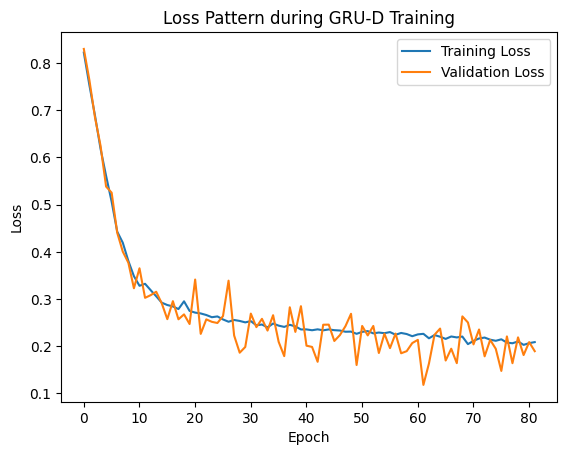

In [45]:
plt.plot(range(len(stats[2])),stats[2], label = 'Training Loss')
plt.plot(range(len(stats[2])),stats[3], label = 'Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss Pattern during GRU-D Training' )

In [460]:

def Test_Binary_Model(model, test_dataloader, title, classes = ['Survived', 'Died']):
    
    if (type(model) == nn.modules.container.Sequential):
        output_last = model[-1].output_last
    else:
        output_last = model.output_last
    
    inputs, labels = next(iter(test_dataloader))
    batch_size= inputs.size(0)

    cur_time = time.time()
    pre_time = time.time()
    
    use_gpu = torch.cuda.is_available()
    if use_gpu == False:
        device = 'cpu'
    
    tested_batch = 0
    
    prob_out = []
    lengths = []
    ground_truth = []
    pred = []

    print("Testing Loop")
   
    model.eval()
    with torch.no_grad():    
        for data in test_dataloader:
            inputs, labels = data
            ground_truth.extend(labels)
            lengths.append(labels.size(1))
            if inputs.shape[0] != batch_size:
                continue
        
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else: 
                inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            prob_out.extend(outputs)
            loss_BSE = torch.nn.BCELoss()

            if output_last:
                predictions = torch.round(outputs)
                pred.extend(predictions)
          
                
            else:
                predictions = torch.round(outputs)
                pred.extend(predictions)
            
            tested_batch += 1
        
            if tested_batch % 1000 == 0:
                cur_time = time.time()
                print('Tested #: {}, time: {}'.format( \
                    tested_batch * batch_size, \

                    np.around([cur_time - pre_time], decimals=8) ) )
                pre_time = cur_time
    
    print('Plotting Matrix')
    # Consolidate lists
    ground_truth = [item for sublist in ground_truth for item in sublist]
    prob_out = [item for sublist in prob_out for item in sublist]
    pred = [item for sublist in pred for item in sublist]
    
    ground_truth = torch.stack(ground_truth)
    prob_out = torch.stack(prob_out).squeeze()
    pred = torch.stack(pred).squeeze()
    

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(np.stack(ground_truth), np.row_stack(pred))
    # Calculate the percentage of each class in the confusion matrix
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure()
    sns.heatmap(conf_matrix_percent, annot=conf_matrix, fmt='d', cmap='Blues', vmin=0, vmax=1)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)    
    plt.yticks(np.arange(len(classes)) + 0.5, classes , rotation=45,fontsize=10)
    plt.xticks(np.arange(len(classes)) + 0.5, classes ,fontsize=10)
    plt.title(title ,fontsize=20)
    plt.show()

    acc = np.diag(conf_matrix).sum()/conf_matrix.sum()
    precision=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
    spec = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    bal_acc = (spec+recall)/2 

    print(f'Accuracy : {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Specificity: {spec:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')

    
    print('Plotting ROC Curves')
    # Calcuations for AUC plots
    # ROC and PRC thresholds
    fpr, tpr, _ = roc_curve(ground_truth, prob_out)
    precis, rec, _ = precision_recall_curve(ground_truth,prob_out)
    print(f'AUROC: {auc(fpr, tpr):.4f}')
    print(f'AUPRC: {auc(rec, precis):.4f}')

    
    # AUROC Plot
    plt.plot(fpr, tpr, marker='o',linestyle='-', label=title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for '+ title)
    plt.legend()
    plt.show()

    #AUPRC Plot
    plt.plot(rec, precis, marker='o',linestyle='-', label=title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PRC for '+ title)
    plt.legend()
    plt.show()

    return prob_out, np.array(lengths), pred, ground_truth

def plot_confusion_matrix(cm, labels, normalize= False, title="Confusion Matrix"):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Testing Loop
Plotting Matrix


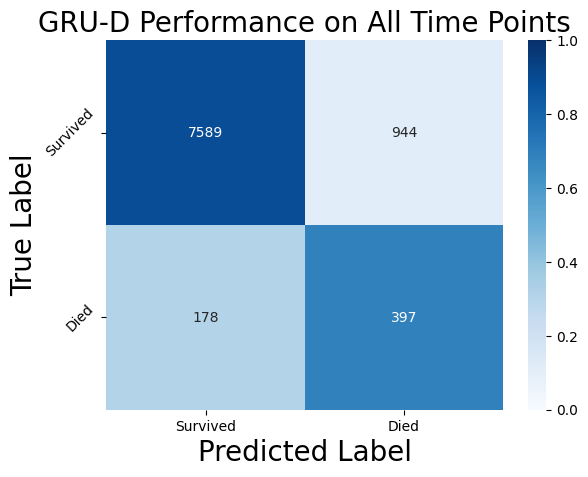

Accuracy : 0.8768
Precision: 0.2960
Specificity: 0.8894
Recall: 0.6904
Balanced Accuracy: 0.7899
Plotting ROC Curves
AUROC: 0.9062
AUPRC: 0.4220


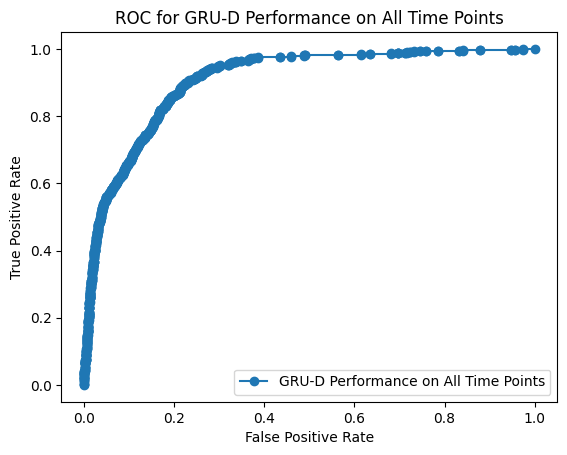

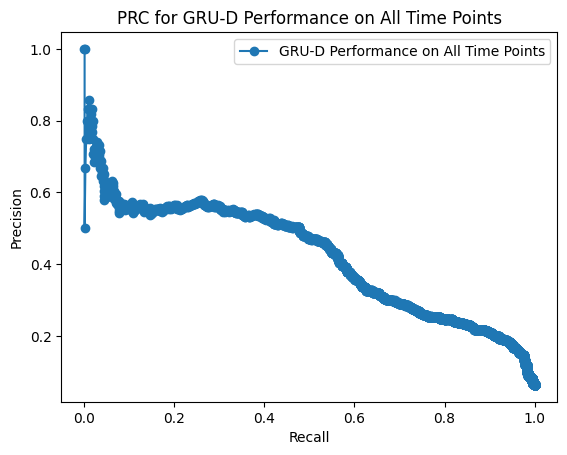

In [608]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

a,b,c,d = Test_Binary_Model(mod, gru_test_dataloader_long, 'GRU-D Performance on All Time Points', classes = ['Survived', 'Died'])
    

In [488]:
episodes[test_idx[indice_mask]]

array([2595., 2151., 2052., 2560., 2121., 2840., 2388., 2366., 2883.,
       2158., 2108., 2457., 2082., 2079., 2673., 2103., 2037., 2655.,
       2605., 2959., 2128., 2593., 2056., 2723., 2481., 2088., 2528.,
       2648., 2104., 2878., 2387., 2680., 2819., 2557., 2438., 2725.,
       2964., 2464., 2443., 2257., 2849., 2834., 2506., 2424., 2936.,
       2982., 2800., 2205., 2243., 2290., 2435., 2724., 2931., 2318.,
       2400., 2540., 2530., 2398., 2862., 2064., 2352., 2211., 2450.,
       2754., 2510., 2176., 2766., 2090., 2268., 2426., 2892., 2992.,
       2118., 2120., 2816., 2672., 2371., 2776., 2633., 2534., 2968.,
       2031., 2761., 2236., 2439., 2674., 2327., 2245., 2507., 2222.,
       2096., 2574., 2757., 2163., 2718., 2857., 2650., 2429., 2254.,
       2709., 2496., 2419., 2149., 2973., 2660., 2374., 2887., 2488.,
       2283., 2872., 2080., 2348., 2100., 2668., 2814., 2302., 2901.,
       2423., 2113., 2676., 2326., 2473., 2232., 2656., 2319., 2934.,
       2525., 2917.,

In [565]:
np.array(df[df['episode_id'].isin(episodes[test_idx[indice_mask]])]['episode_id'].unique(), dtype = 'int')

array([2018, 2031, 2037, 2048, 2052, 2056, 2064, 2079, 2080, 2082, 2088,
       2090, 2096, 2100, 2103, 2104, 2108, 2113, 2118, 2120, 2121, 2128,
       2144, 2149, 2151, 2158, 2163, 2171, 2176, 2182, 2205, 2208, 2211,
       2222, 2232, 2236, 2243, 2245, 2254, 2257, 2259, 2268, 2269, 2282,
       2283, 2290, 2302, 2318, 2319, 2323, 2326, 2327, 2332, 2333, 2348,
       2352, 2366, 2371, 2374, 2387, 2388, 2398, 2399, 2400, 2404, 2419,
       2423, 2424, 2426, 2429, 2432, 2435, 2438, 2439, 2443, 2450, 2457,
       2464, 2465, 2472, 2473, 2481, 2488, 2492, 2496, 2503, 2506, 2507,
       2510, 2517, 2525, 2528, 2530, 2531, 2534, 2535, 2539, 2540, 2557,
       2560, 2571, 2574, 2577, 2581, 2582, 2593, 2595, 2601, 2605, 2609,
       2613, 2633, 2648, 2650, 2655, 2656, 2660, 2668, 2672, 2673, 2674,
       2676, 2679, 2680, 2692, 2709, 2713, 2718, 2723, 2724, 2725, 2734,
       2739, 2754, 2757, 2758, 2761, 2766, 2776, 2777, 2794, 2795, 2798,
       2800, 2805, 2814, 2816, 2819, 2829, 2834, 28

In [615]:
test_episodes = episodes[test_idx[indice_mask]]
test_episodes

array([2595., 2151., 2052., 2560., 2121., 2840., 2388., 2366., 2883.,
       2158., 2108., 2457., 2082., 2079., 2673., 2103., 2037., 2655.,
       2605., 2959., 2128., 2593., 2056., 2723., 2481., 2088., 2528.,
       2648., 2104., 2878., 2387., 2680., 2819., 2557., 2438., 2725.,
       2964., 2464., 2443., 2257., 2849., 2834., 2506., 2424., 2936.,
       2982., 2800., 2205., 2243., 2290., 2435., 2724., 2931., 2318.,
       2400., 2540., 2530., 2398., 2862., 2064., 2352., 2211., 2450.,
       2754., 2510., 2176., 2766., 2090., 2268., 2426., 2892., 2992.,
       2118., 2120., 2816., 2672., 2371., 2776., 2633., 2534., 2968.,
       2031., 2761., 2236., 2439., 2674., 2327., 2245., 2507., 2222.,
       2096., 2574., 2757., 2163., 2718., 2857., 2650., 2429., 2254.,
       2709., 2496., 2419., 2149., 2973., 2660., 2374., 2887., 2488.,
       2283., 2872., 2080., 2348., 2100., 2668., 2814., 2302., 2901.,
       2423., 2113., 2676., 2326., 2473., 2232., 2656., 2319., 2934.,
       2525., 2917.,

In [670]:
_,_, g = EWS_seq_extraction_short(df, test_episodes, 'mews', 24)

np.array(g.groupby('episode_id').size())

array([18, 11, 15, 24, 35, 21, 27, 17, 16, 10, 15, 28, 27, 27, 23, 23, 14,
       19, 16, 12, 14, 12, 23, 23, 10, 13, 18, 37, 13, 14,  4,  4,  5,  4,
        4,  5,  4,  4,  4,  5,  8,  6,  4,  5,  5,  5,  4,  5,  5,  6,  5,
        5,  5,  8,  5,  5,  5,  6,  4,  5,  4,  9,  4,  6,  4,  4,  5,  4,
        4,  5,  5, 14,  4, 12,  4,  4,  7,  5,  5,  4,  5,  4,  5,  7,  5,
        4, 11,  4,  4,  4,  4,  4,  4,  9,  4,  5,  5,  4,  5,  4,  4,  4,
        5,  4,  5,  5,  5,  4,  5,  5,  4,  4,  4,  5,  5,  5,  5,  4,  4,
        4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  5,  5,  5,  4,  5,
        4,  4,  5,  4,  5,  4,  4,  4,  4,  9,  5,  5,  4,  4,  4,  4,  8,
        4,  4,  5,  5,  4,  4,  4,  8,  5,  5,  4,  7,  5,  5,  4,  4,  5,
        4,  5,  4,  5,  5,  5,  6,  5,  4])

In [672]:
def ews_time_point_results (df, test_episodes, EWS, long_or_short, hrs_to_trim = 24):
    '''
    Wrapper function that extracts EWS sequence with ground truth labels
    Uses Functions: EWS_seq_extraction_long/short to extract labels and EWS_metrics_time_point to plot
    Input: df: vital signs/EWS, test_episodes: Array of episode_id in test_set, EWS: string of EWS, long_or_short: string of eval type, hrs_to_trim: no. hours from end
    Output: CFM, AUROC, AUPRC plots and tuple of (Specificity, Recall, Balanced Accuracy, AUROC, AUPRC)
    '''
    assert long_or_short in {'long', 'short'}, 'Select Type of Eval: "long", "short"'
    assert EWS in {'mews','news2','ecart'}, 'Select valid EWS: "news2", "mews", "ecart"'

    if long_or_short == 'long':
        labels, ews_seq = EWS_seq_extraction_long(df, test_episodes, EWS)
    elif long_or_short == 'short':
        labels, ews_seq, _ = EWS_seq_extraction_short(df, test_episodes, EWS, hrs_to_trim)
    
    return EWS_metrics_time_point(labels, ews_seq, EWS , long_or_short)

def EWS_seq_extraction_long (df, test_episodes, EWS):
    '''
    Extracts all time points within test set
    Output: Tuple of 2x array: ground_truth , EWS Sequence
    '''
    # Selects episodes within Test set
    data = df[df['episode_id'].isin(test_episodes)]
    labels = data['outcome_in_24hrs']
    ews_seq = data[EWS]

    return labels, ews_seq
    
def EWS_seq_extraction_short (df, test_episodes, EWS, hrs_to_trim = 24):
    '''
    Extracts time points within last Xhrs from each sequence test set
    Output: Tuple of 3x array: ground_truth , EWS Sequence, Sequence Length
    '''
    assert EWS in {'mews','news2','ecart'}, 'Select valid EWS: "news2", "mews", "ecart"'
    # Selects episodes within Test set
    data = df[df['episode_id'].isin(test_episodes)][['episode_id','anchor_time','outcome_in_24hrs', EWS]].reset_index()
    # For each episode find the maximum time and substract window hours (default 24hrs == 1440mins) and store in dict
    epi = (data.groupby('episode_id')['anchor_time'].max()-(hrs_to_trim*60)).index
    val = (data.groupby('episode_id')['anchor_time'].max()-(hrs_to_trim*60)).values
    epi_dict = dict(zip(epi, val))

    # Select all observations within last X hrs of sequence
    data['time_threshold'] = data['episode_id'].map(epi_dict)
    data = data[data['anchor_time'] >= data['time_threshold']].reset_index()

    labels = data['outcome_in_24hrs']
    ews_seq = data[EWS]
    lengths = np.array(data.groupby('episode_id').size())

    return labels, ews_seq, lengths


def EWS_metrics_time_point (labels, ews_seq, EWS , long_or_short = 'long', classes = ['Survived', 'Died']):
    '''
    Takes sequences of labels and EWS scores and applies threshold 
    Output: Plots of CFM, AUROC, AUPRC plots and tuple of (Specificity, Recall, Balanced Accuracy, AUROC, AUPRC)
    '''
    # Logic for Formatting
    if long_or_short == 'long':
        title = 'All Time Points '
    elif long_or_short == 'short':
        title = 'Last 24hrs '
    
    # Logic for thresholds of EWS
    if EWS == 'mews':
        threshold = 5
    elif EWS == 'news2':
        threshold = 7
    elif EWS == 'ecart':
        threshold = 20    

    # AUC/AUPRC Metrics
    # Iterate through the sequence of possible EWS scores for TPR/FPR/Precision
    TPR = []
    FPR = []
    prec_thres =[]
    max_score = int(ews_seq.max())
    for i in range(max_score):
        conf_matrix = confusion_matrix(labels , ews_seq >=i)
        recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
        spec = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        precision=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[0,1])
        TPR.append(recall)
        prec_thres.append(precision)
        FPR.append(1-spec)
    
    auroc = metrics.auc(FPR, TPR)
    auprc = metrics.auc(TPR, prec_thres)

    # Metrics according to specificed threshold
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(labels, ews_seq >= threshold)
    # Calculate the percentage of each class in the confusion matrix
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure()
    sns.heatmap(conf_matrix_percent, annot=conf_matrix, fmt='d', cmap='Blues', vmin=0, vmax=1)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)    
    plt.yticks(np.arange(len(classes)) + 0.5, classes , rotation=45,fontsize=10)
    plt.xticks(np.arange(len(classes)) + 0.5, classes ,rotation=45,fontsize=10)
    plt.title(title + 'Confusion Matrix for ' + EWS ,fontsize=20)
    plt.show()

    acc = np.diag(conf_matrix).sum()/conf_matrix.sum()
    spec = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    bal_acc = (spec+recall)/2 

    print(f'Accuracy : {acc:.4f}')
    print(f'Specificity: {spec:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')

    # AUROC Plot
    plt.plot(FPR, TPR, marker='o',linestyle='-', label=EWS)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + 'AUROC for '+ EWS)
    plt.legend()
    plt.ylim(-0.01,1.01)
    plt.xlim(-0.01,1.01)
    plt.show()
    print(f'AUROC: {auroc:.4f}')

    #AUPRC Plot
    plt.plot(TPR, prec_thres, marker='o',linestyle='-', label=EWS)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title + 'AUPRC for '+ EWS)
    plt.ylim(-0.01,1.01)
    plt.xlim(-0.01,1.01)
    plt.legend()
    plt.show()
    print(f'AUPRC: {auprc:.4f}')

    return spec, recall, bal_acc, auroc, auprc

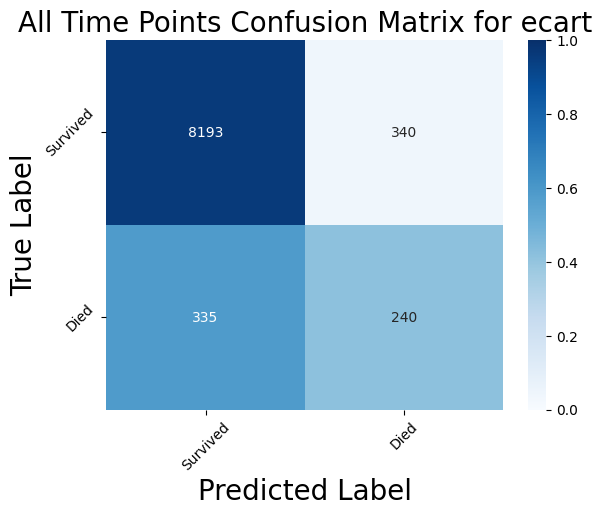

Accuracy : 0.9259
Specificity: 0.9602
Recall: 0.4174
Balanced Accuracy: 0.6888


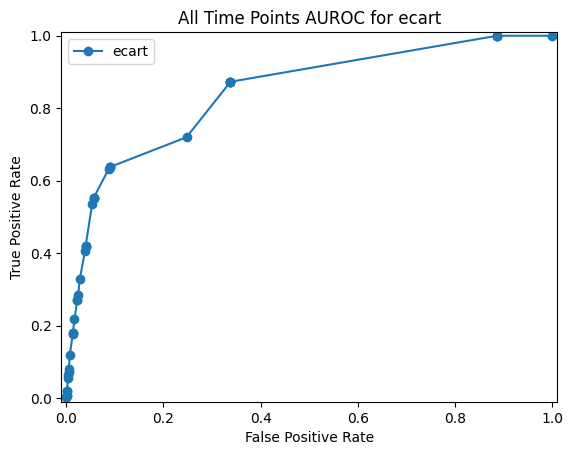

AUROC: 0.8436


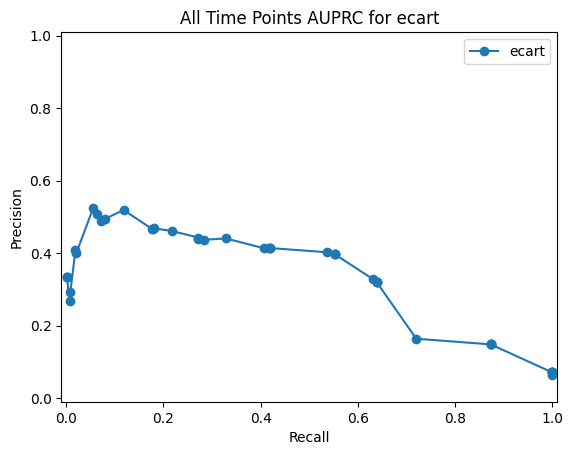

AUPRC: 0.3326


(0.9601546935427165,
 0.41739130434782606,
 0.6887729989452713,
 0.843583733739599,
 0.33255605456863213)

In [652]:
ews_time_point_results (df, test_episodes, 'ecart', 'long')

In [493]:
df['mews']>4

0        False
1        False
2         True
3        False
4        False
         ...  
47120    False
47121    False
47122    False
47123    False
47124    False
Name: mews, Length: 47125, dtype: bool

In [318]:
df[df['episode_id'] == 2151]

,episode_id,anchor_time,sbp,dbp,hr,temp,rr,spo2,flow,outcome_in_24hrs,age,mews,ecart,news2
10056,2151.0,384.0,119.0,75.0,46.0,37.322393,9.0,100.0,1.0,False,69.0,1,4,7
10057,2151.0,728.0,128.0,90.0,47.0,37.454567,12.0,99.0,0.0,True,69.0,1,4,1
10058,2151.0,1124.0,116.0,75.0,57.0,37.731221,9.0,100.0,0.0,True,69.0,0,4,1
10059,2151.0,1259.0,80.0,58.0,112.0,37.566530,14.0,99.0,6.0,True,69.0,4,8,10
10060,2151.0,1376.0,92.0,72.0,119.0,37.365828,19.0,98.0,4.0,True,69.0,4,8,9
10061,2151.0,1485.0,102.0,82.0,113.0,37.347762,13.0,99.0,3.0,True,69.0,2,8,8
10062,2151.0,1581.0,82.0,60.0,110.0,37.671813,21.0,98.0,6.0,True,69.0,4,16,11
10063,2151.0,1701.0,97.0,78.0,111.0,38.073449,18.0,96.0,6.0,True,69.0,4,8,8
10064,2151.0,1826.0,84.0,63.0,106.0,37.693039,13.0,99.0,6.0,True,69.0,2,4,9
10065,2151.0,1945.0,94.0,74.0,105.0,37.441002,12.0,99.0,7.0,True,69.0,2,4,8


In [319]:
episodes[595]

2595.0

In [388]:
test_idx[indice_mask]

array([595, 151,  52, 560, 121, 840, 388, 366, 883, 158, 108, 457,  82,
        79, 673, 103,  37, 655, 605, 959, 128, 593,  56, 723, 481,  88,
       528, 648, 104, 878, 387, 680, 819, 557, 438, 725, 964, 464, 443,
       257, 849, 834, 506, 424, 936, 982, 800, 205, 243, 290, 435, 724,
       931, 318, 400, 540, 530, 398, 862,  64, 352, 211, 450, 754, 510,
       176, 766,  90, 268, 426, 892, 992, 118, 120, 816, 672, 371, 776,
       633, 534, 968,  31, 761, 236, 439, 674, 327, 245, 507, 222,  96,
       574, 757, 163, 718, 857, 650, 429, 254, 709, 496, 419, 149, 973,
       660, 374, 887, 488, 283, 872,  80, 348, 100, 668, 814, 302, 901,
       423, 113, 676, 326, 473, 232, 656, 319, 934, 525, 917, 259, 282,
       905, 465, 144, 908, 734, 679, 795, 858, 794, 577, 399, 692, 404,
       582, 999, 517, 332, 182, 829, 758, 798, 269,  48, 531, 539, 581,
       805, 432, 837, 571, 739,  18, 503, 777, 713, 171, 472, 535, 864,
       946, 323, 333, 208, 601, 613, 492, 609, 913, 955])

In [353]:
def gru_d_prob_seq_extractor (prob_seq, lengths, idx):
    assert idx < len(lengths), 'Must Valid Index within Test Set'
    assert idx >= 0, 'Must be Valid Index'
   
    ending_idx = lengths.cumsum()
    if idx == 0:
        return prob_seq[0:ending_idx[idx]]
    else:
        start = ending_idx[(idx-1)]
        return prob_seq[start: ending_idx[idx]]


In [464]:
def plot_vitals_gru_d_prob (episodes, test_idx, prob_seq, lengths, idx):

    episode_id = int(episodes[test_idx[idx]])
    data = df[df['episode_id'] == episode_id]

    fig, ax1 = plt.subplots()
    ti = data['anchor_time']


    prob_seq = gru_d_prob_seq_extractor (prob_seq, lengths, idx)
  
    # Plot the Vital Signs with ax1

    line1, = ax1.plot(ti,  data['sbp'], linewidth = 0.5, label='SBP (mmHg)')
    line2, = ax1.plot(ti,  data['dbp'], linewidth = 0.5, label='DBP(mmHg)')
    line3, = ax1.plot(ti,  data['hr'], linewidth = 0.5, label='HR (bpm)')
    line4, = ax1.plot(ti,  data['temp'], linewidth = 0.5, label='Temp ($^o$C)')
    line5, = ax1.plot(ti,  data['rr'], linewidth = 0.5, label='RR (min$^-$$^1$)')
    line6, = ax1.plot(ti,  data['spo2'], linewidth = 0.5, label='SpO$_2$ (%)')
    line7, = ax1.plot(ti,  data['flow'], linewidth = 0.5, label='O$_2$ Flow Rate (L/min)')

    ax1.set_xlabel('Time Since Admission (Min)')
    ax1.set_ylabel('Vitals')
    # ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    line8, = ax2.plot(ti, prob_seq,  color = 'k', linestyle = '-.', label='Model Output')
    line9, = ax2.plot([ti.min(), ti.max()], [0.5,0.5], linestyle = '--', color = 'firebrick', label='Model Threshold')
    ax2.set_ylabel('Probability of Adverse Outcome')
    # ax2.set_yticks([0,1], labels= ['Stable', 'Unstable'])
    ax2.set_ylim(-0.05,1.05)
    ax2.set_title('GRU-D Output with Episode ID: '+ str(episode_id))
    ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    plt.show()

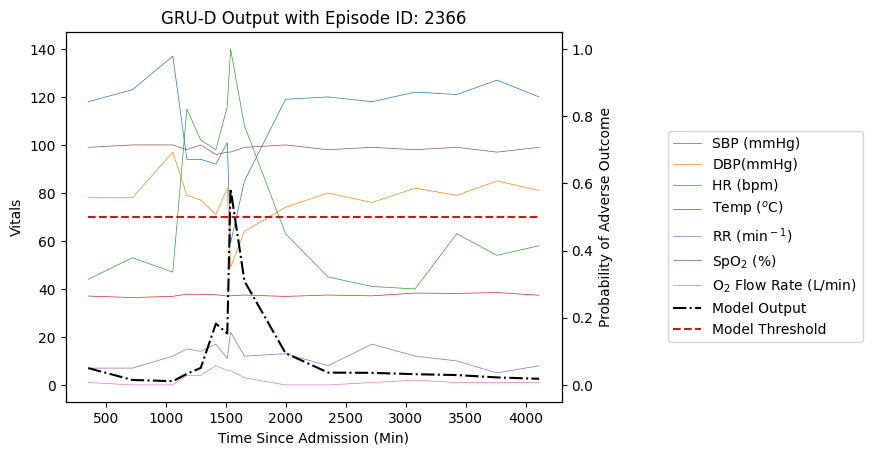

In [646]:
plot_vitals_gru_d_prob(episodes, test_idx[indice_mask], a, b, 7)

In [483]:
def plot_vitals_news (episodes, test_idx, idx):

    episode_id = int(episodes[test_idx[idx]])
    data = df[df['episode_id'] == episode_id]

    fig, ax1 = plt.subplots()
    ti = data['anchor_time']

    
    news_seq = data['news2']
  
    # Plot the Vital Signs with ax1

    line1, = ax1.plot(ti,  data['sbp'], linewidth = 0.5, label='SBP (mmHg)')
    line2, = ax1.plot(ti,  data['dbp'], linewidth = 0.5, label='DBP(mmHg)')
    line3, = ax1.plot(ti,  data['hr'], linewidth = 0.5, label='HR (bpm)')
    line4, = ax1.plot(ti,  data['temp'], linewidth = 0.5, label='Temp ($^o$C)')
    line5, = ax1.plot(ti,  data['rr'], linewidth = 0.5, label='RR (min$^-$$^1$)')
    line6, = ax1.plot(ti,  data['spo2'], linewidth = 0.5, label='SpO$_2$ (%)')
    line7, = ax1.plot(ti,  data['flow'], linewidth = 0.5, label='O$_2$ Flow Rate (L/min)')

    ax1.set_xlabel('Time Since Admission (Min)')
    ax1.set_ylabel('Vitals')
    # ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    line8, = ax2.plot(ti, news_seq,  color = 'k', linestyle = '-.', label='NEWS2 Score')
    line9, = ax2.plot([ti.min(), ti.max()], [7,7], linestyle = '--', color = 'firebrick', label = 'Threshold')
    ax2.set_ylabel('NEWS2 Score')
    # ax2.set_yticks([0,1], labels= ['Stable', 'Unstable'])
    ax2.set_ylim(-2,21)
    ax2.set_title('NEWS2 Output on Episode ID: '+ str(episode_id))
    ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    plt.show()

def plot_vitals_mews (episodes, test_idx, idx):

    episode_id = int(episodes[test_idx[idx]])
    data = df[df['episode_id'] == episode_id]

    fig, ax1 = plt.subplots()
    ti = data['anchor_time']

    
    news_seq = data['mews']
  
    # Plot the Vital Signs with ax1

    line1, = ax1.plot(ti,  data['sbp'], linewidth = 0.5, label='SBP (mmHg)')
    line2, = ax1.plot(ti,  data['dbp'], linewidth = 0.5, label='DBP(mmHg)')
    line3, = ax1.plot(ti,  data['hr'], linewidth = 0.5, label='HR (bpm)')
    line4, = ax1.plot(ti,  data['temp'], linewidth = 0.5, label='Temp ($^o$C)')
    line5, = ax1.plot(ti,  data['rr'], linewidth = 0.5, label='RR (min$^-$$^1$)')
    line6, = ax1.plot(ti,  data['spo2'], linewidth = 0.5, label='SpO$_2$ (%)')
    line7, = ax1.plot(ti,  data['flow'], linewidth = 0.5, label='O$_2$ Flow Rate (L/min)')

    ax1.set_xlabel('Time Since Admission (Min)')
    ax1.set_ylabel('Vitals')
    # ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    line8, = ax2.plot(ti, news_seq,  color = 'k', linestyle = '-.', label='MEWS Score')
    line9, = ax2.plot([ti.min(), ti.max()], [5,5], linestyle = '--', color = 'firebrick', label = 'Threshold')
    ax2.set_ylabel('MEWS Score')
    # ax2.set_yticks([0,1], labels= ['Stable', 'Unstable'])
    ax2.set_ylim(-1,15)
    ax2.set_title('MEWS Output on Episode ID: '+ str(episode_id))
    ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    plt.show()

def plot_vitals_ecart (episodes, test_idx, idx):

    episode_id = int(episodes[test_idx[idx]])
    data = df[df['episode_id'] == episode_id]

    fig, ax1 = plt.subplots()
    ti = data['anchor_time']

    
    news_seq = data['ecart']
  
    # Plot the Vital Signs with ax1

    line1, = ax1.plot(ti,  data['sbp'], linewidth = 0.5, label='SBP (mmHg)')
    line2, = ax1.plot(ti,  data['dbp'], linewidth = 0.5, label='DBP(mmHg)')
    line3, = ax1.plot(ti,  data['hr'], linewidth = 0.5, label='HR (bpm)')
    line4, = ax1.plot(ti,  data['temp'], linewidth = 0.5, label='Temp ($^o$C)')
    line5, = ax1.plot(ti,  data['rr'], linewidth = 0.5, label='RR (min$^-$$^1$)')
    line6, = ax1.plot(ti,  data['spo2'], linewidth = 0.5, label='SpO$_2$ (%)')
    line7, = ax1.plot(ti,  data['flow'], linewidth = 0.5, label='O$_2$ Flow Rate (L/min)')

    ax1.set_xlabel('Time Since Admission (Min)')
    ax1.set_ylabel('Vitals')
    # ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    # Create a second y-axis sharing the same x-axis
    ax2 = ax1.twinx()

    line8, = ax2.plot(ti, news_seq,  color = 'k', linestyle = '-.', label='eCART Score')
    line9, = ax2.plot([ti.min(), ti.max()], [20,20], linestyle = '--', color = 'firebrick', label = 'Threshold')
    ax2.set_ylabel('eCART Score')
    # ax2.set_yticks([0,1], labels= ['Stable', 'Unstable'])
    ax2.set_ylim(-3,50)
    ax2.set_title('eCART Output on Episode ID: '+ str(episode_id))
    ax1.legend(handles=[line1, line2, line3, line4, line5, line6, line7, line8, line9], loc='upper left', bbox_to_anchor=(1.2, 0.75))
    plt.show()

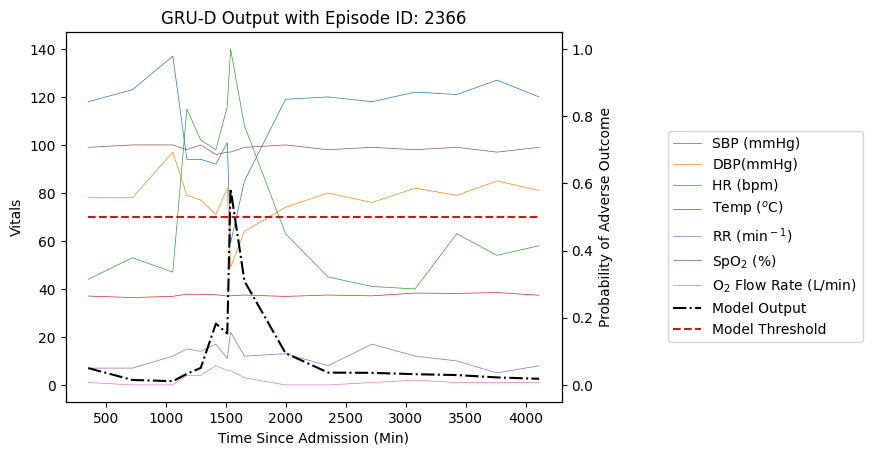

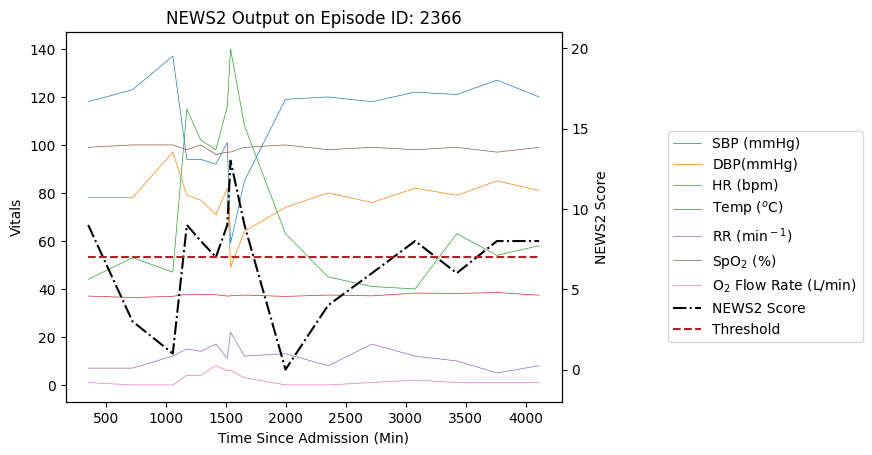

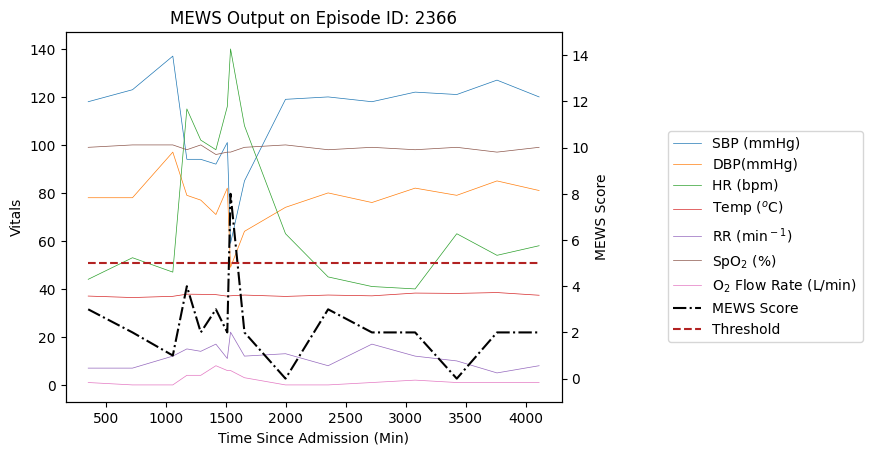

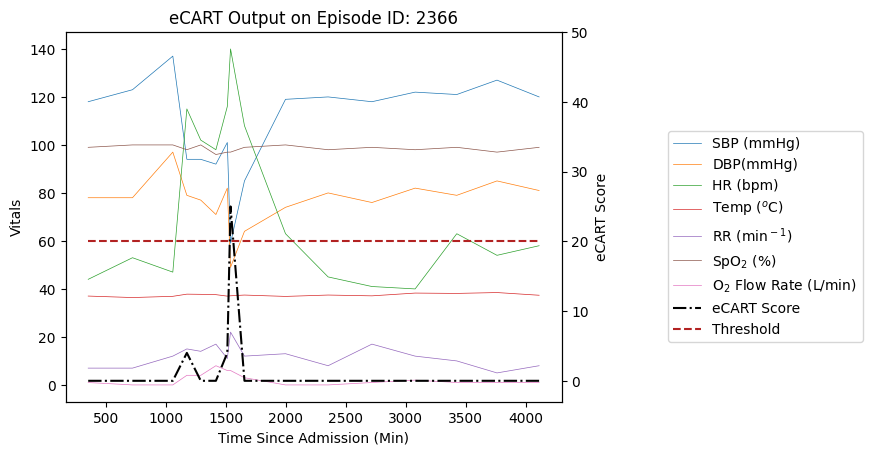

In [484]:
plot_vitals_gru_d_prob(episodes, test_idx[indice_mask], a, b, 7)
plot_vitals_news (episodes, test_idx[indice_mask], 7)
plot_vitals_mews (episodes, test_idx[indice_mask], 7)
plot_vitals_ecart (episodes, test_idx[indice_mask], 7)

## Assessment of Last 24 hours

Testing Loop
Plotting Matrix


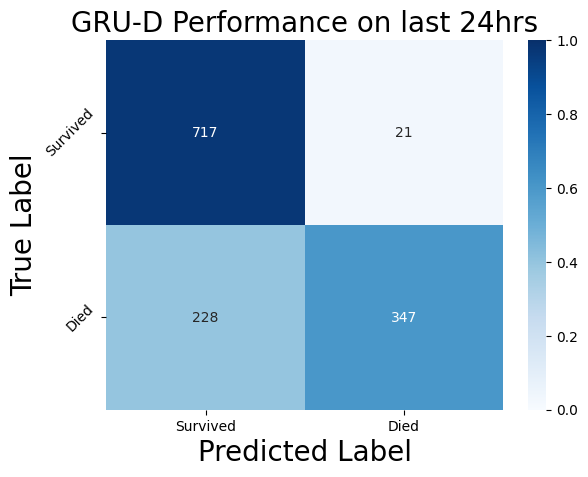

Accuracy : 0.8104
Precision: 0.9429
Specificity: 0.9715
Recall: 0.6035
Balanced Accuracy: 0.7875
Plotting ROC Curves
AUROC: 0.9538
AUPRC: 0.9386


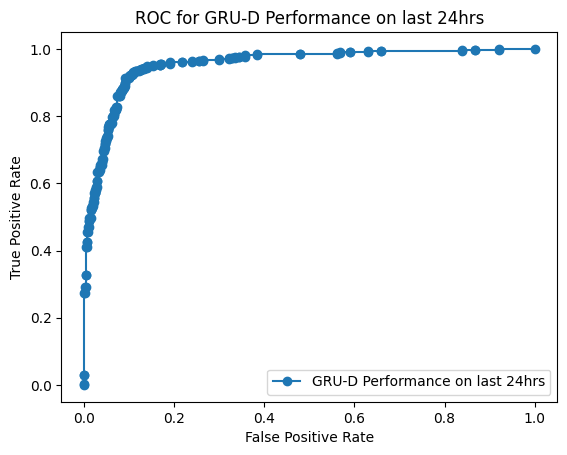

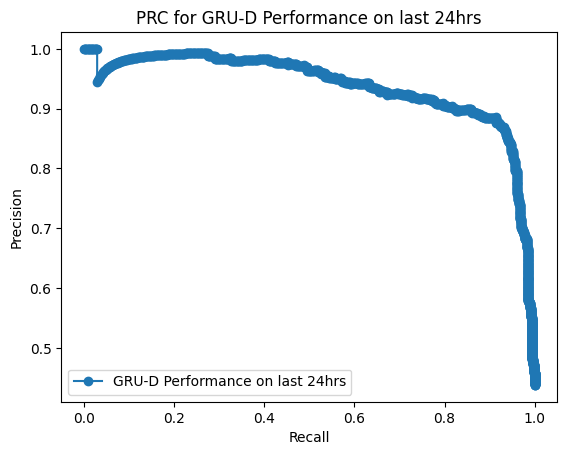

In [1026]:

a,b,c,d = Test_Binary_Model(mod, gru_test_dataloader_short, 'GRU-D Performance on last 24hrs', classes = ['Survived', 'Died'])
    

In [1027]:
def RNN_24_extractor (last_24_length, ground_truth, prob_out, pred):
    short_ground_truth = []
    short_probilities = []
    short_predictions = []
    idx = 0
    for length in last_24_length:
        start = idx
        end = idx + length
        short_ground_truth.append(ground_truth[start:end])
        short_probilities.append(prob_out[start:end])
        short_predictions.append(pred[start:end])
        idx += length

    return short_ground_truth, short_probilities, short_predictions

short_ground_truth, short_probilities, short_predictions = RNN_24_extractor(b,d,a,c)

In [781]:
def EWS_seq_extraction_short (df, test_episodes, EWS, hrs_to_trim = 24):
    '''
    Extracts time points within last Xhrs from each sequence test set
    Output: Tuple of 3x array: ground_truth , EWS Sequence, Sequence Length
    '''
    assert EWS in {'mews','news2','ecart'}, 'Select valid EWS: "news2", "mews", "ecart"'
    # Selects episodes within Test set
    data = df[df['episode_id'].isin(test_episodes)][['episode_id','anchor_time','outcome_in_24hrs', EWS]].reset_index()
    # For each episode find the maximum time and substract window hours (default 24hrs == 1440mins) and store in dict
    epi = (data.groupby('episode_id')['anchor_time'].max()-(hrs_to_trim*60)).index
    val = (data.groupby('episode_id')['anchor_time'].max()-(hrs_to_trim*60)).values
    epi_dict = dict(zip(epi, val))

    # Select all observations within last X hrs of sequence
    data['time_threshold'] = data['episode_id'].map(epi_dict)
    data = data[data['anchor_time'] >= data['time_threshold']].reset_index()

    labels = data['outcome_in_24hrs']
    ews_seq = data[EWS]
    lengths = np.array(data.groupby('episode_id').size())
    timings = data['anchor_time']

    return labels, ews_seq, lengths, np.array(epi), timings

In [988]:
def ews_24_extractor (seq_lengths, ground_truth_seq, ews_score_seq, time_seq):
    '''
    Converts as long sequences into the list of variable length sequences according to length
    Inputs: Seq_length (Array of lengths of each sequence), ground_truth_seq (raw sequence of labels), ews_score_seq (raw sequence of EWS Scores)
    outpus: Tuple (list of variable length sequences (labels, EWS Scores))
    '''
    label_sequences = []
    ews_sequences = []
    timing_sequences = []

    idx = 0
    for length in seq_lengths:
        start = idx
        end = idx + length
        label_sequences.append(ground_truth_seq[start:end])
        ews_sequences.append(ews_score_seq[start:end])
        # Need values for indexing later
        timing_sequences.append(time_seq[start:end].values)
        idx += length
    
    return label_sequences, ews_sequences, timing_sequences

def ews_seq_metric_deviation (label_sequences, ews_sequences, EWS):
    '''
    Evalutates metrics at a Sequence level
    Takes list of variable lengths arranaged in [Instance, Time_step]
    Outputs Sequence level metrics in Tuple 
    Input: Ground_truth, Probability_output
    '''

    # Logic for thresholds of EWS
    if EWS == 'mews':
        threshold = 5
    elif EWS == 'news2':
        threshold = 7
    elif EWS == 'ecart':
        threshold = 20    
    
    # Derive probability sequences in case you needed AUROC/AUPRC
    max_score = np.zeros(len(ews_sequences))
    for i in range(max_score.shape[0]):
        # If empty -> make it zero prediction
        if len(ews_sequences[i]) == 0:
            max_score[i]= 0
        # Take the max as this will be the breach of threshold
        else:
            max_score[i] = ews_sequences[i].max()

    # Derive the sequence level - Differs from the ground truth in shortened sequence as some may not have any time point
    seq_ground_truth = np.zeros(len(label_sequences))
    id= 0
    # each sequence take the max label which will be 0/1
    for seq in label_sequences:
        seq_ground_truth[id] = seq.max()
        id+= 1

    # Accuracy metrics -> Round threshold (0.5)
    conf_matrix = confusion_matrix(seq_ground_truth, (max_score>=threshold))
    spec = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    bal_acc = (spec+recall)/2 
  
    # Extract the sequences where there was a correct prediction
    indices = np.where((seq_ground_truth == (max_score>=threshold) ) & (seq_ground_truth ==1))[0]
    

    print('Sequence Level Prediction for '+ EWS)
    print(f'Specificity: {spec:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')

    return ( spec, recall, bal_acc), indices, threshold

def first_warning_timing_extraction_ews (list_ews_scores, threshold, list_timings, indices):
    '''
    Function giving the time (mins) from event where the first warning is given.  Uses func find_first_occurance 
    Inputs: list_seq (list of variable length EWS scores), threshold (int of threshold for EWS), list_timings (list of time of each observation), indices (idx of correct sequences)
    Outpus: Array of time (mins) of first warning
    '''
    
    first_warnings = np.zeros(indices.shape[0])
    
    id = 0
    # Iterate through correctly identified seq in test_set
    for i in indices:
        # Pull each ews sequence and find where threshold breached
        seq_pred = list_ews_scores[i].values >= threshold
        # Find idx where threshold first breached
        timing_idx = find_first_occurrence(seq_pred, 1)

        # Add time to first warning array
        first_warnings[id] = (list_timings[int(i)][timing_idx])
        
        id += 1

    return first_warnings


In [1054]:
def ews_short_sequence_metrics (df, test_episodes, EWS, hrs_to_trim = 24):
    '''
    Wrapper function to extract the last X hours of each sequence to evaluate the sequence level prediction
    Uses functions: EWS_seq_extraction_short (Extracts the last X hours), ews_24_extractor (compiles sequences into list of variable length sequences)
    ews_seq_metric_deviation (Provide metrics and episode_id of correctly identified sequences with adverse outcomes)
    Inputs: df (vital signs/EWS), test_episodes (array of episodes in test set), EWS: string of EWS type, hrs_to_trim: Xhrs to trim
    Outputs: 2x Tuples: seq_level_results: (Specificity, Recall, Balanced Accuracy), (first warning with episodes)
    '''
    assert EWS in {'mews','news2','ecart'}, 'Select valid EWS: "news2", "mews", "ecart"'
    
    ground_truth_seq, ews_score_seq, seq_lengths, episode_list, time_seq = EWS_seq_extraction_short(df, test_episodes, EWS, hrs_to_trim)

    label_sequences, ews_sequences, timing_sequences = ews_24_extractor (seq_lengths, ground_truth_seq, ews_score_seq, time_seq)
    seq_level_results, correct_idx, threshold = ews_seq_metric_deviation (label_sequences, ews_sequences, EWS)
    
    # Transform anchor_times to time to event
    timing_sequences = time_to_event_transform(timing_sequences)
    first_warnings = first_warning_timing_extraction_ews (ews_sequences, threshold, timing_sequences, correct_idx)
    correct_episodes = episode_list[correct_idx]

    return seq_level_results, (first_warnings, correct_episodes)


Sequence Level Prediction for mews
Specificity: 0.8926
Recall: 1.0000
Balanced Accuracy: 0.9463
Sequence Level Prediction for ecart
Specificity: 0.9597
Recall: 0.9333
Balanced Accuracy: 0.9465
Sequence Level Prediction for news2
Specificity: 0.0872
Recall: 1.0000
Balanced Accuracy: 0.5436
Sequence Level Prediction for GRU-D
Specificity: 0.9463
Recall: 1.0000
Balanced Accuracy: 0.9732


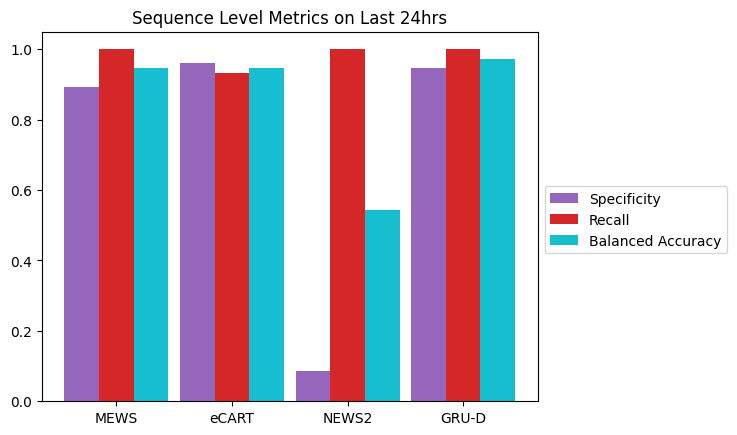

In [1055]:

mews_short_seq = ews_short_sequence_metrics(df, test_episodes, 'mews', 24)
ecart_short_seq = ews_short_sequence_metrics(df, test_episodes, 'ecart', 24)
news_short_seq = ews_short_sequence_metrics(df, test_episodes, 'news2', 24)
gru_short_seq = gru_seq_metrics (a, b, c, d, short_timings, episodes, test_idx, indice_mask)


plt_labels = ['MEWS', 'eCART', 'NEWS2', 'GRU-D']
seq_results = np.zeros((4,3))

seq_results[0] = mews_short_seq[0]
seq_results[1] = ecart_short_seq[0]
seq_results[2] = news_short_seq[0]
seq_results[3] = gru_short_seq[0]

plt.bar(np.arange(4)-0.3, seq_results[:,0], width = 0.3, color = 'C4', label = 'Specificity')
plt.bar(np.arange(4), seq_results[:,1], width = 0.3, color = 'C3', label = 'Recall')
plt.bar(np.arange(4)+0.3, seq_results[:,2], width = 0.3, color = 'C9', label = 'Balanced Accuracy')
plt.xticks(np.arange(4), labels=plt_labels)
plt.title('Sequence Level Metrics on Last 24hrs')
plt.legend (bbox_to_anchor=(1, 0.6))
plt.show()


In [1011]:


def gru_seq_extractor (last_24_length, ground_truth, prob_out, pred):
    short_ground_truth = []
    short_probilities = []
    short_predictions = []
    idx = 0
    for length in last_24_length:
        start = idx
        end = idx + length
        short_ground_truth.append(ground_truth[start:end])
        short_probilities.append(prob_out[start:end])
        short_predictions.append(pred[start:end])
        idx += length

    return short_ground_truth, short_probilities, short_predictions

short_ground_truth, short_probilities, short_predictions = RNN_24_extractor(b,d,a,c)


def gru_seq_metric_deviation (ground_truth, prob_out):
    '''
    Evalutates metrics at a Sequence level
    Takes list of variable lengths arranaged in [Instance, Time_step]
    Outputs Time_Point Metrics in Tuple 
    Input: Ground_truth, Probability_output, Prediction (0/1)
    '''
    # Derive probability sequences in case you needed AUROC/AUPRC
    seq_prob = np.zeros(len(prob_out))
    for i in range(seq_prob.shape[0]):
        # If empty -> make it zero prediction
        if len(prob_out[i]) == 0:
            seq_prob[i]= 0
        # Take the max as this will be the breach of threshold
        else:
            seq_prob[i] = prob_out[i].max()

    # Derive the sequence level - Differs from the ground truth in shortened sequence as some may not have any time point
    seq_ground_truth = np.zeros(len(ground_truth))
    id= 0
    # each sequence take the max label which will be 0/1
    for seq in ground_truth:
        seq_ground_truth[id] = seq.max()
        id+= 1

    # Accuracy metrics -> Round threshold (0.5)
    conf_matrix = confusion_matrix(seq_ground_truth, np.round(seq_prob) )
    spec = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
    recall=conf_matrix[1,1]/(conf_matrix[1,1]+conf_matrix[1,0])
    bal_acc = (spec+recall)/2 
    
  
    # Extract the sequences where there was a correct prediction
    indices = np.where((seq_ground_truth == np.round(seq_prob)) & (seq_ground_truth ==1))[0]

    print('Sequence Level Prediction for GRU-D')
    print(f'Specificity: {spec:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Balanced Accuracy: {bal_acc:.4f}')

    return ( spec, recall, bal_acc), indices

def first_warning_timing_extraction (list_seq, list_timings, indices):
    first_warnings = np.zeros(indices.shape[0])
    id = 0
    for i in indices:
        timing_idx = int(find_first_occurrence(list_seq[int(i)], 1))
        first_warnings[id] = (list_timings[int(i)][timing_idx])
        id += 1

    return first_warnings

def find_first_occurrence(arr, value):
    '''
    Finds the index of event prediction
    Within the list/array, find the indices
    Return the index of the first occurance
    If no positive prediction -> returns NaN
    '''
    result = np.where(arr == value)[0]
    if result.size > 0:
        return int(result[0])
    else:
        return np.nan  # Return -1 if the no value is not found

def time_to_event_transform (timings):
    time_to_event = []
    for seq in timings:
        time_to_event.append(seq.max() - seq)

    return time_to_event


def gru_seq_metrics (prob_out, seq_lengths, pred, labels, short_timings, episodes, test_idx, indice_mask):
    '''
    Wrapper for gru
    '''
    
    short_ground_truth, short_probilities, short_predictions = gru_seq_extractor (seq_lengths, labels, prob_out, pred)
    seq_results, correct_idx = gru_seq_metric_deviation (short_ground_truth, short_probilities)
    
    short_timings = time_to_event_transform(short_timings)
    first_warnings = first_warning_timing_extraction(short_predictions, short_timings , correct_idx)

    correct_episodes = episodes[test_idx[indice_mask][correct_idx]]

    return seq_results, (first_warnings, correct_episodes)

## Timings

In [1057]:
warnings = (mews_short_seq[1][0],  ecart_short_seq[1][0], news_short_seq[1][0], gru_short_seq[1][0])
warnings

(array([ 392.,   95., 1420., 1429.,  934.,  847.,  930., 1375.,   83.,
         128., 1037., 1097., 1007.,  707.,  377.,  826., 1035.,  275.,
         951.,  222.,   75.,  172., 1029., 1290.,    0.,  867.,  558.,
        1411.,    0.,   25.]),
 array([ 392.,   66.,   68., 1429.,  909.,  375.,  513.,  153.,   83.,
         128., 1037.,  565.,  974.,  707.,  377.,  826.,  275.,  951.,
         222.,   75.,  172.,  391.,  323.,   94.,  107., 1411.,    0.,
          25.]),
 array([ 431., 1343., 1420., 1429., 1209., 1068., 1301., 1375., 1401.,
         991., 1417., 1347., 1392., 1423., 1406., 1298., 1409., 1389.,
        1332., 1104., 1323.,  640., 1394., 1413.,  706.,  978., 1409.,
        1411., 1366., 1347.]),
 array([   0.,  934.,  482.,   94.,  706.,   67.,  153.,  377.,  214.,
         160.,  375., 1037.,  399.,  930.,  510.,  737.,  951.,  184.,
          95.,  974.,  558., 1066.,  497.,  656.,  901.,  807.,  640.,
        1429.,  337., 1411.]))

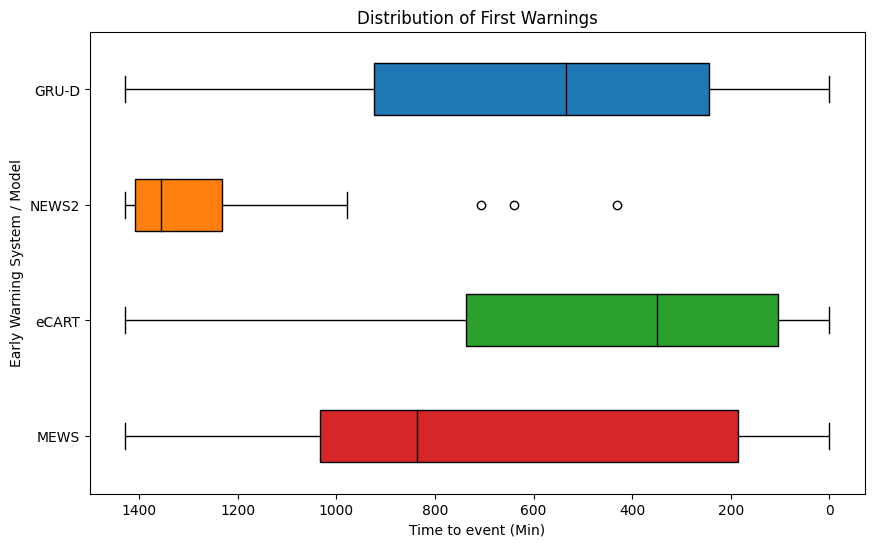

In [1058]:
plt.figure(figsize= (10,6))
box = plt.boxplot(warnings,medianprops = dict(color='k'), patch_artist=True, vert = False,showfliers=True)

colors = ['C3', 'C2', 'C1', 'C0']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribution of First Warnings')
plt.yticks([1, 2, 3, 4], ['MEWS', 'eCART', 'NEWS2',  'GRU-D'])
plt.ylabel('Early Warning System / Model')
plt.xlabel('Time to event (Min)')
plt.gca().invert_xaxis()

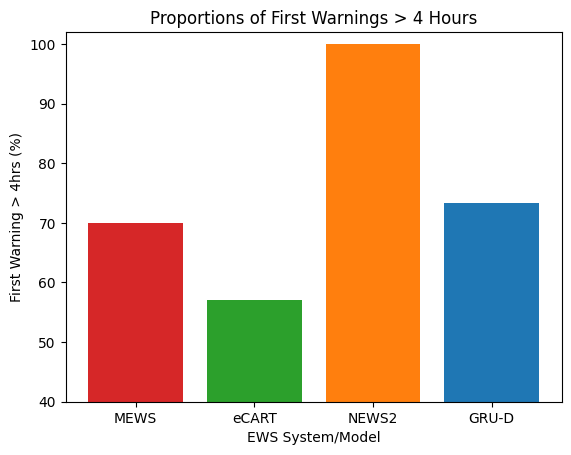

MEWS Warning proportions > 4 Hours:  70.0
eCART Warning proportions > 4 Hours:  57.14
NEWS2 Warning proportions > 4 Hours:  100.0
GRU-D Warning proportions > 4 Hours:  73.33


In [1059]:
warning_proportions = np.zeros(4)
id=0
for group in warnings:
    warning_proportions[id] = ((group>240).sum() / group.shape)*100
    id+=1

l = np.array(['MEWS', 'eCART', 'NEWS2', 'GRU-D'])
plt.bar([0], warning_proportions[0], width= 0.8, label = 'MEWS', color = 'C3')
plt.bar([1], warning_proportions[1], width= 0.8, label = 'eCART', color = 'C2')
plt.bar([2], warning_proportions[2], width= 0.8, label = 'NEWS2', color = 'C1')
plt.bar([3], warning_proportions[3], width= 0.8, label = 'GRU-D', color = 'C0')

plt.ylabel('First Warning > 4hrs (%)')
plt.xlabel('EWS System/Model')
plt.title('Proportions of First Warnings > 4 Hours')

plt.xticks(range(len(l)), labels=l)
plt.ylim(40,102)
plt.show()

for i in range(4):
    print (l[i] , 'Warning proportions > 4 Hours: ' , warning_proportions[i].round(2))

In [1061]:
epi_warnings = (mews_short_seq[1][1],  ecart_short_seq[1][1], news_short_seq[1][1], gru_short_seq[1][1])
epi_warnings

(array([2018., 2031., 2037., 2048., 2052., 2056., 2064., 2079., 2080.,
        2082., 2088., 2090., 2096., 2100., 2103., 2104., 2108., 2113.,
        2118., 2120., 2121., 2128., 2144., 2149., 2151., 2158., 2163.,
        2171., 2176., 2182.]),
 array([2018., 2031., 2037., 2048., 2052., 2056., 2064., 2079., 2080.,
        2082., 2088., 2090., 2096., 2100., 2103., 2104., 2113., 2118.,
        2120., 2121., 2128., 2144., 2149., 2158., 2163., 2171., 2176.,
        2182.]),
 array([2018., 2031., 2037., 2048., 2052., 2056., 2064., 2079., 2080.,
        2082., 2088., 2090., 2096., 2100., 2103., 2104., 2108., 2113.,
        2118., 2120., 2121., 2128., 2144., 2149., 2151., 2158., 2163.,
        2171., 2176., 2182.]),
 array([2151., 2052., 2121., 2158., 2108., 2082., 2079., 2103., 2037.,
        2128., 2056., 2088., 2104., 2064., 2176., 2090., 2118., 2120.,
        2031., 2096., 2163., 2149., 2080., 2100., 2113., 2144., 2182.,
        2048., 2018., 2171.]))

In [1088]:
from scipy.stats import mannwhitneyu

def mann_whitney_comparision (warnings, epi_warnings, EWS1, EWS2):
    assert EWS1 in {'MEWS','eCART','NEWS2', 'GRU-D'}, "Select valid EWS: 'MEWS','eCART','NEWS2', 'GRU-D'"
    assert EWS2 in {'MEWS','eCART','NEWS2', 'GRU-D'}, "Select valid EWS: 'MEWS','eCART','NEWS2', 'GRU-D'"

    if EWS1 == 'MEWS':
        first_idx = 0
    elif EWS1 == 'eCART':
        first_idx = 1
    elif EWS1 == 'NEWS2':
        first_idx = 2
    elif EWS1 == 'GRU-D':
        first_idx = 3
    
    if EWS2 == 'MEWS':
        sec_idx = 0
    elif EWS2 == 'eCART':
        sec_idx = 1
    elif EWS2 == 'NEWS2':
        sec_idx = 2
    elif EWS2 == 'GRU-D':
        sec_idx = 3

    first_group = warnings[first_idx][np.isin(epi_warnings[first_idx], epi_warnings[sec_idx])]
    sec_group = warnings[sec_idx][np.isin(epi_warnings[sec_idx], epi_warnings[first_idx])]

    _, p = mannwhitneyu((first_group), (sec_group), method="asymptotic")

    print('Pairwise Mann-Whitney-U Comparision between',EWS1, '&', EWS2, ':', p)

    return p


In [1091]:
mann_whitney_comparision (warnings, epi_warnings, 'MEWS', 'GRU-D')

Pairwise Mann-Whitney-U Comparision between MEWS & GRU-D : 0.45969157236794733


0.45969157236794733